# exp23: exp22最適化パラメータ + Rolling Window Validation

**ベースライン**: exp22 (Holdout Validation)

**背景**:
- exp22で冗長な特徴量を削減（50 → 37）
- exp22でOptuna再最適化を実施
- Holdout Validationでの評価は完了

**exp23の目的**:
- exp22の最適化パラメータと特徴量（37個）を使用
- Rolling Window Validationで時系列に頑健な評価を実施
- exp20（50特徴量 + Rolling）との比較

**Rolling Window設定**:
- 8ウィンドウ（exp20と同じ）
- 各ウィンドウ: Train 12ヶ月 → Test 2ヶ月

**使用パラメータ（exp22最適化）**:
- Ridge: alpha=0.337
- ExtraTrees: n_estimators=274, max_depth=11, etc.
- HistGradientBoosting: max_iter=183, learning_rate=0.018, etc.
- CatBoost: iterations=1547, learning_rate=0.043, depth=4, etc.

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import warnings
warnings.filterwarnings('ignore')
import os

# 出力ディレクトリ
output_dir = '../output/exp23'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [2]:
# ==================================================================================
# exp22で最適化されたパラメータ
# ==================================================================================

OPTIMIZED_PARAMS_EXP22 = {
    'Ridge': {
        'alpha': 0.33687714881527253
    },
    'ExtraTrees': {
        'n_estimators': 274,
        'max_depth': 11,
        'min_samples_split': 29,
        'min_samples_leaf': 4,
        'max_features': None
    },
    'HistGradientBoosting': {
        'max_iter': 183,
        'learning_rate': 0.018120547421615427,
        'max_depth': 30,
        'min_samples_leaf': 6,
        'l2_regularization': 0.022360855923847303
    },
    'CatBoost': {
        'iterations': 1547,
        'learning_rate': 0.04313835983436318,
        'depth': 4,
        'l2_leaf_reg': 0.13964878723609409,
        'subsample': 0.8418882107293159
    }
}

print('exp22で最適化されたパラメータを読み込みました')
print('\nパラメータ詳細:')
for model_name, params in OPTIMIZED_PARAMS_EXP22.items():
    print(f'\n{model_name}:')
    for key, value in params.items():
        print(f'  {key}: {value}')

exp22で最適化されたパラメータを読み込みました

パラメータ詳細:

Ridge:
  alpha: 0.33687714881527253

ExtraTrees:
  n_estimators: 274
  max_depth: 11
  min_samples_split: 29
  min_samples_leaf: 4
  max_features: None

HistGradientBoosting:
  max_iter: 183
  learning_rate: 0.018120547421615427
  max_depth: 30
  min_samples_leaf: 6
  l2_regularization: 0.022360855923847303

CatBoost:
  iterations: 1547
  learning_rate: 0.04313835983436318
  depth: 4
  l2_leaf_reg: 0.13964878723609409
  subsample: 0.8418882107293159


In [3]:
# ==================================================================================
# データの読み込みと特徴量作成（exp22と同じ）
# ==================================================================================

def load_and_preprocess_data():
    calender = pd.read_csv('../input/calender_data.csv')
    cm_data = pd.read_csv('../input/cm_data.csv')
    gt_service = pd.read_csv('../input/gt_service_name.csv')
    acc_get = pd.read_csv('../input/regi_acc_get_data_transform.csv')
    call_data = pd.read_csv('../input/regi_call_data_transform.csv')
    
    calender['cdr_date'] = pd.to_datetime(calender['cdr_date'])
    cm_data['cdr_date'] = pd.to_datetime(cm_data['cdr_date'])
    acc_get['cdr_date'] = pd.to_datetime(acc_get['cdr_date'])
    call_data['cdr_date'] = pd.to_datetime(call_data['cdr_date'])
    gt_service['week'] = pd.to_datetime(gt_service['week'])
    
    return calender, cm_data, gt_service, acc_get, call_data

def merge_datasets(calender, cm_data, gt_service, acc_get, call_data):
    df = call_data.copy()
    df = df.merge(calender, on='cdr_date', how='left')
    df = df.merge(cm_data, on='cdr_date', how='left')
    df = df.merge(acc_get, on='cdr_date', how='left')
    
    gt_service_daily = []
    for idx, row in gt_service.iterrows():
        week_start = row['week']
        for i in range(7):
            date = week_start + timedelta(days=i)
            gt_service_daily.append({'cdr_date': date, 'search_cnt': row['search_cnt']})
    
    gt_daily = pd.DataFrame(gt_service_daily)
    df = df.merge(gt_daily, on='cdr_date', how='left')
    
    return df

def create_basic_time_features(df):
    df = df.copy()
    df['year'] = df['cdr_date'].dt.year
    df['month'] = df['cdr_date'].dt.month
    df['day_of_month'] = df['cdr_date'].dt.day
    df['quarter'] = df['cdr_date'].dt.quarter
    df['day_of_year'] = df['cdr_date'].dt.dayofyear
    df['week_of_year'] = df['cdr_date'].dt.isocalendar().week
    df['days_from_start'] = (df['cdr_date'] - df['cdr_date'].min()).dt.days
    df['is_month_start'] = (df['day_of_month'] <= 5).astype(int)
    df['is_month_end'] = (df['day_of_month'] >= 25).astype(int)
    return df

def create_lag_features(df, target_col='call_num', lags=[1, 2, 3, 5, 7, 14, 30]):
    df = df.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df

def create_rolling_features(df, target_col='call_num', windows=[3, 7, 14, 30]):
    df = df.copy()
    for window in windows:
        df[f'ma_{window}'] = df[target_col].shift(1).rolling(window=window, min_periods=1).mean()
        df[f'ma_std_{window}'] = df[target_col].shift(1).rolling(window=window, min_periods=1).std()
    return df

def create_aggregated_features(df):
    df = df.copy()
    df['cm_7d'] = df['cm_flg'].shift(1).rolling(window=7, min_periods=1).sum()
    df['gt_ma_7'] = df['search_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    df['acc_ma_7'] = df['acc_get_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    
    df['dow_avg'] = np.nan
    for dow in df['dow'].unique():
        mask = df['dow'] == dow
        df.loc[mask, 'dow_avg'] = df.loc[mask, 'call_num'].shift(1).expanding().mean()
    
    return df

def create_regime_change_features(df):
    df = df.copy()
    
    tax_implementation_date = pd.Timestamp('2019-10-01')
    rush_deadline = pd.Timestamp('2019-09-30')
    
    df['days_to_2019_10_01'] = (tax_implementation_date - df['cdr_date']).dt.days
    df['is_post_2019_10_01'] = (df['cdr_date'] >= tax_implementation_date).astype(int)
    df['is_post_2019_09_30'] = (df['cdr_date'] >= rush_deadline).astype(int)
    
    rush_start = rush_deadline - pd.Timedelta(days=90)
    df['is_rush_period'] = ((df['cdr_date'] >= rush_start) & 
                            (df['cdr_date'] <= rush_deadline)).astype(int)
    
    adaptation_end = tax_implementation_date + pd.Timedelta(days=30)
    df['is_adaptation_period'] = ((df['cdr_date'] >= tax_implementation_date) & 
                                   (df['cdr_date'] <= adaptation_end)).astype(int)
    
    return df

print('データ読み込み・特徴量作成関数を定義しました')

データ読み込み・特徴量作成関数を定義しました


In [4]:
# ==================================================================================
# データ準備
# ==================================================================================

print("*" * 80)
print("exp23: exp22最適化パラメータ + Rolling Window Validation")
print("*" * 80)

calender, cm_data, gt_service, acc_get, call_data = load_and_preprocess_data()
df = merge_datasets(calender, cm_data, gt_service, acc_get, call_data)
df = create_basic_time_features(df)
df = create_lag_features(df)
df = create_rolling_features(df)
df = create_aggregated_features(df)
df = create_regime_change_features(df)

# 翌日の入電数を目的変数にする
df['target_next_day'] = df['call_num'].shift(-1)
df = df.dropna(subset=['target_next_day']).reset_index(drop=True)

# 平日のみ
df_model = df[df['dow'].isin([1, 2, 3, 4, 5])].copy().reset_index(drop=True)

print(f"\n平日データ数: {len(df_model)}行")
print(f"期間: {df_model['cdr_date'].min()} ~ {df_model['cdr_date'].max()}")

********************************************************************************
exp23: exp22最適化パラメータ + Rolling Window Validation
********************************************************************************

平日データ数: 477行
期間: 2018-06-01 00:00:00 ~ 2020-03-30 00:00:00


In [5]:
# ==================================================================================
# exp22の特徴量（37個）
# ==================================================================================

feature_cols = [
    # 基本時系列特徴量
    'dow', 'day_of_month', 'year', 
    'day_of_year', 'week_of_year',
    'is_month_start', 'is_month_end',
    # カレンダー特徴量
    'day_before_holiday_flag',
    # 外部データ
    'cm_flg', 'acc_get_cnt', 'search_cnt',
    # 集約特徴量
    'cm_7d', 'gt_ma_7', 'acc_ma_7', 'dow_avg',
    # ラグ特徴量
    'lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_7', 'lag_14', 'lag_30',
    # 移動平均特徴量（ma_14, ma_std_14削除済み）
    'ma_3', 'ma_7', 'ma_30',
    'ma_std_3', 'ma_std_7', 'ma_std_30',
    # レジーム変化特徴量（is_pre_*削除済み）
    'days_to_2019_10_01', 'is_post_2019_10_01',
    'is_post_2019_09_30',
    'is_rush_period', 'is_adaptation_period',
]

print(f"使用する特徴量数: {len(feature_cols)}")
print("\n【特徴量一覧】")
for i, feat in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {feat}")

# 欠損値を除去
df_clean = df_model.dropna(subset=feature_cols + ['target_next_day']).copy()
print(f"\n欠損値除去後: {len(df_clean)}行")

使用する特徴量数: 33

【特徴量一覧】
   1. dow
   2. day_of_month
   3. year
   4. day_of_year
   5. week_of_year
   6. is_month_start
   7. is_month_end
   8. day_before_holiday_flag
   9. cm_flg
  10. acc_get_cnt
  11. search_cnt
  12. cm_7d
  13. gt_ma_7
  14. acc_ma_7
  15. dow_avg
  16. lag_1
  17. lag_2
  18. lag_3
  19. lag_5
  20. lag_7
  21. lag_14
  22. lag_30
  23. ma_3
  24. ma_7
  25. ma_30
  26. ma_std_3
  27. ma_std_7
  28. ma_std_30
  29. days_to_2019_10_01
  30. is_post_2019_10_01
  31. is_post_2019_09_30
  32. is_rush_period
  33. is_adaptation_period

欠損値除去後: 456行


In [6]:
# ==================================================================================
# Rolling Window Validation 設定（exp20と同じ）
# ==================================================================================

print("\n" + "=" * 80)
print("Rolling Window Validation 設定")
print("=" * 80)

# ウィンドウ設定
train_months = 12
test_months = 2
n_windows = 8

# 開始日と終了日
data_start = df_clean['cdr_date'].min()
data_end = df_clean['cdr_date'].max()

print(f"\nデータ期間: {data_start.strftime('%Y-%m-%d')} ~ {data_end.strftime('%Y-%m-%d')}")
print(f"Train期間: {train_months}ヶ月")
print(f"Test期間: {test_months}ヶ月")
print(f"ウィンドウ数: {n_windows}")

# ウィンドウを生成
windows = []
first_test_start = pd.Timestamp('2018-11-01')

for i in range(n_windows):
    test_start = first_test_start + pd.DateOffset(months=i * test_months)
    test_end = test_start + pd.DateOffset(months=test_months) - pd.Timedelta(days=1)
    train_start = test_start - pd.DateOffset(months=train_months)
    train_end = test_start - pd.Timedelta(days=1)
    
    windows.append({
        'window': i + 1,
        'train_start': train_start,
        'train_end': train_end,
        'test_start': test_start,
        'test_end': test_end
    })

print("\n【ウィンドウ詳細】")
for w in windows:
    print(f"  Window {w['window']}: Train {w['train_start'].strftime('%Y-%m-%d')} ~ {w['train_end'].strftime('%Y-%m-%d')} | Test {w['test_start'].strftime('%Y-%m-%d')} ~ {w['test_end'].strftime('%Y-%m-%d')}")


Rolling Window Validation 設定

データ期間: 2018-07-02 ~ 2020-03-30
Train期間: 12ヶ月
Test期間: 2ヶ月
ウィンドウ数: 8

【ウィンドウ詳細】
  Window 1: Train 2017-11-01 ~ 2018-10-31 | Test 2018-11-01 ~ 2018-12-31
  Window 2: Train 2018-01-01 ~ 2018-12-31 | Test 2019-01-01 ~ 2019-02-28
  Window 3: Train 2018-03-01 ~ 2019-02-28 | Test 2019-03-01 ~ 2019-04-30
  Window 4: Train 2018-05-01 ~ 2019-04-30 | Test 2019-05-01 ~ 2019-06-30
  Window 5: Train 2018-07-01 ~ 2019-06-30 | Test 2019-07-01 ~ 2019-08-31
  Window 6: Train 2018-09-01 ~ 2019-08-31 | Test 2019-09-01 ~ 2019-10-31
  Window 7: Train 2018-11-01 ~ 2019-10-31 | Test 2019-11-01 ~ 2019-12-31
  Window 8: Train 2019-01-01 ~ 2019-12-31 | Test 2020-01-01 ~ 2020-02-29


In [7]:
# ==================================================================================
# 評価関数
# ==================================================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

def evaluate_model(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'WAPE': calculate_wape(y_true, y_pred)
    }

print('評価関数を定義しました')

評価関数を定義しました


---

# Rolling Window Validation 実行

In [8]:
# ==================================================================================
# Rolling Window Validation 実行
# ==================================================================================

from sklearn.linear_model import Ridge
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from catboost import CatBoostRegressor
from scipy.optimize import minimize

print("\n" + "=" * 80)
print("Rolling Window Validation 実行")
print("=" * 80)

all_results = []

for w in windows:
    window_num = w['window']
    print(f"\n" + "-" * 60)
    print(f"Window {window_num}")
    print(f"-" * 60)
    
    # Train/Test分割
    train_mask = (df_clean['cdr_date'] >= w['train_start']) & (df_clean['cdr_date'] <= w['train_end'])
    test_mask = (df_clean['cdr_date'] >= w['test_start']) & (df_clean['cdr_date'] <= w['test_end'])
    
    train_df = df_clean[train_mask].copy()
    test_df = df_clean[test_mask].copy()
    
    if len(train_df) == 0 or len(test_df) == 0:
        print(f"  スキップ（データ不足）: Train={len(train_df)}, Test={len(test_df)}")
        continue
    
    X_train = train_df[feature_cols]
    y_train = train_df['target_next_day']
    X_test = test_df[feature_cols]
    y_test = test_df['target_next_day']
    
    print(f"  Train: {len(X_train)}件, Test: {len(X_test)}件")
    
    predictions = {}
    
    # 1. Ridge
    ridge = Ridge(**OPTIMIZED_PARAMS_EXP22['Ridge'], random_state=42)
    ridge.fit(X_train, y_train)
    ridge_pred = ridge.predict(X_test)
    ridge_metrics = evaluate_model(y_test, ridge_pred)
    predictions['Ridge'] = ridge_pred
    all_results.append({'window': window_num, 'model': 'Ridge', **ridge_metrics})
    
    # 2. ExtraTrees
    extra = ExtraTreesRegressor(**OPTIMIZED_PARAMS_EXP22['ExtraTrees'], random_state=42, n_jobs=-1)
    extra.fit(X_train, y_train)
    extra_pred = extra.predict(X_test)
    extra_metrics = evaluate_model(y_test, extra_pred)
    predictions['ExtraTrees'] = extra_pred
    all_results.append({'window': window_num, 'model': 'ExtraTrees', **extra_metrics})
    
    # 3. HistGradientBoosting
    hist = HistGradientBoostingRegressor(**OPTIMIZED_PARAMS_EXP22['HistGradientBoosting'], random_state=42)
    hist.fit(X_train, y_train)
    hist_pred = hist.predict(X_test)
    hist_metrics = evaluate_model(y_test, hist_pred)
    predictions['HistGradientBoosting'] = hist_pred
    all_results.append({'window': window_num, 'model': 'HistGradientBoosting', **hist_metrics})
    
    # 4. CatBoost
    catboost = CatBoostRegressor(**OPTIMIZED_PARAMS_EXP22['CatBoost'], random_state=42, verbose=0)
    catboost.fit(X_train, y_train)
    catboost_pred = catboost.predict(X_test)
    catboost_metrics = evaluate_model(y_test, catboost_pred)
    predictions['CatBoost'] = catboost_pred
    all_results.append({'window': window_num, 'model': 'CatBoost', **catboost_metrics})
    
    # 5. WeightedEnsemble（Testセットで重み最適化）
    def optimize_weights(preds_dict, y_true, model_names):
        preds_matrix = np.column_stack([preds_dict[name] for name in model_names])
        def objective(weights):
            ensemble_pred = preds_matrix @ weights
            return mean_absolute_error(y_true, ensemble_pred)
        constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}
        bounds = [(0, 1) for _ in range(len(model_names))]
        initial_weights = np.ones(len(model_names)) / len(model_names)
        result = minimize(objective, initial_weights, method='SLSQP',
                         bounds=bounds, constraints=constraints)
        return result.x
    
    ensemble_models = ['Ridge', 'CatBoost', 'ExtraTrees', 'HistGradientBoosting']
    weights = optimize_weights(predictions, y_test, ensemble_models)
    ensemble_pred = np.column_stack([predictions[name] for name in ensemble_models]) @ weights
    ensemble_metrics = evaluate_model(y_test, ensemble_pred)
    all_results.append({'window': window_num, 'model': 'WeightedEnsemble', **ensemble_metrics})
    
    # 結果表示
    print(f"  Ridge MAE: {ridge_metrics['MAE']:.2f}")
    print(f"  ExtraTrees MAE: {extra_metrics['MAE']:.2f}")
    print(f"  HistGradientBoosting MAE: {hist_metrics['MAE']:.2f}")
    print(f"  CatBoost MAE: {catboost_metrics['MAE']:.2f}")
    print(f"  WeightedEnsemble MAE: {ensemble_metrics['MAE']:.2f}")

print("\n" + "=" * 80)
print("Rolling Window Validation 完了")
print("=" * 80)


Rolling Window Validation 実行

------------------------------------------------------------
Window 1
------------------------------------------------------------
  Train: 88件, Test: 43件
  Ridge MAE: 111.87
  ExtraTrees MAE: 37.63
  HistGradientBoosting MAE: 56.95
  CatBoost MAE: 86.06
  WeightedEnsemble MAE: 37.63

------------------------------------------------------------
Window 2
------------------------------------------------------------
  Train: 131件, Test: 43件
  Ridge MAE: 70.11
  ExtraTrees MAE: 66.18
  HistGradientBoosting MAE: 59.01
  CatBoost MAE: 65.45
  WeightedEnsemble MAE: 57.77

------------------------------------------------------------
Window 3
------------------------------------------------------------
  Train: 174件, Test: 43件
  Ridge MAE: 36.29
  ExtraTrees MAE: 18.87
  HistGradientBoosting MAE: 18.40
  CatBoost MAE: 20.69
  WeightedEnsemble MAE: 15.83

------------------------------------------------------------
Window 4
-----------------------------------------

In [9]:
# ==================================================================================
# 結果の集計
# ==================================================================================

results_df = pd.DataFrame(all_results)

print("\n" + "=" * 80)
print("全ウィンドウの結果")
print("=" * 80)
print(results_df.to_string(index=False))

# モデル別の平均スコア
print("\n" + "=" * 80)
print("モデル別 平均スコア（8ウィンドウ）")
print("=" * 80)

avg_results = results_df.groupby('model').agg({
    'MAE': ['mean', 'std'],
    'RMSE': ['mean', 'std'],
    'R2': ['mean', 'std'],
    'WAPE': ['mean', 'std']
}).round(3)

avg_results.columns = ['_'.join(col) for col in avg_results.columns]
avg_results = avg_results.reset_index().sort_values('MAE_mean')
print(avg_results.to_string(index=False))

# CSVに保存
results_df.to_csv(f'{output_dir}/rolling_window_results.csv', index=False)
avg_results.to_csv(f'{output_dir}/rolling_window_avg_results.csv', index=False)
print(f"\n保存しました:")
print(f"  {output_dir}/rolling_window_results.csv")
print(f"  {output_dir}/rolling_window_avg_results.csv")


全ウィンドウの結果
 window                model        MAE       RMSE        R2       WAPE
      1                Ridge 111.867505 135.502008 -3.889024 112.653460
      1           ExtraTrees  37.631735  46.668393  0.420069  37.896127
      1 HistGradientBoosting  56.954288  66.505938 -0.177746  57.354436
      1             CatBoost  86.056257  95.261313 -1.416372  86.660868
      1     WeightedEnsemble  37.631735  46.668393  0.420069  37.896127
      2                Ridge  70.105018  83.867261 -0.876351 128.825461
      2           ExtraTrees  66.179928  86.669279 -1.003824 121.612687
      2 HistGradientBoosting  59.014887  75.708495 -0.529038 108.446159
      2             CatBoost  65.454890  79.720256 -0.695378 120.280353
      2     WeightedEnsemble  57.774542  74.306718 -0.472941 106.166894
      3                Ridge  36.292922  45.195116  0.499072  33.684344
      3           ExtraTrees  18.868648  26.480666  0.828031  17.512451
      3 HistGradientBoosting  18.399333  25.342266  0

---

# exp20との比較


exp20 vs exp23 比較

【平均MAE比較】
               model  exp20_MAE (50 features)  exp23_MAE (37 features)  improvement
    WeightedEnsemble                      NaN                46.064347          NaN
          ExtraTrees                57.773265                53.283608     4.489657
HistGradientBoosting                65.461163                55.007866    10.453297
            CatBoost                67.687692                59.243524     8.444167
               Ridge                86.884105                77.826554     9.057551

【CatBoost ウィンドウ別比較】
 window  exp20_MAE  exp23_MAE  improvement
      1  58.788640  86.056257   -27.267617
      2  53.220916  65.454890   -12.233974
      3  37.922123  20.689309    17.232814
      4  46.335902  20.898903    25.436998
      5 162.760776  73.769306    88.991470
      6  93.613472  97.653340    -4.039868
      7  56.329183  69.565396   -13.236213
      8  32.530521  39.860791    -7.330270


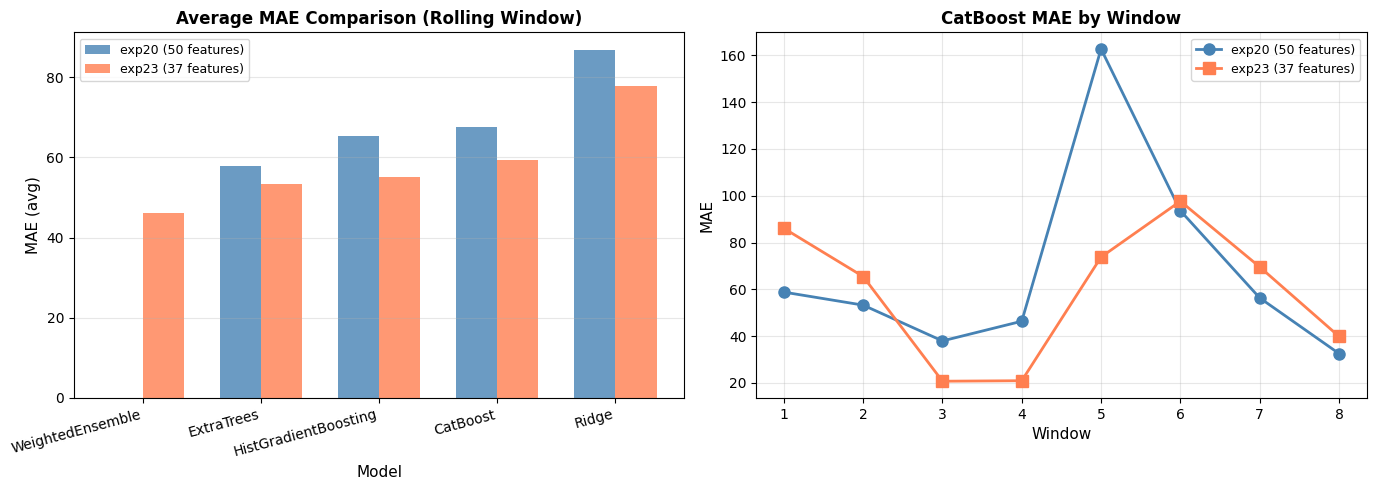


保存しました: ../output/exp23/exp20_vs_exp23_comparison.csv


In [10]:
# ==================================================================================
# exp20（50特徴量 + Rolling）との比較
# ==================================================================================

import matplotlib.pyplot as plt

print("\n" + "=" * 80)
print("exp20 vs exp23 比較")
print("=" * 80)

exp20_path = '../output/exp20/rolling_window_results.csv'
if os.path.exists(exp20_path):
    exp20_df = pd.read_csv(exp20_path)
    
    # 各モデルの平均MAEを比較
    exp20_avg = exp20_df.groupby('model')['MAE'].mean()
    exp23_avg = results_df.groupby('model')['MAE'].mean()
    
    comparison_data = []
    for model in exp23_avg.index:
        exp20_mae = exp20_avg.get(model, np.nan)
        exp23_mae = exp23_avg.get(model, np.nan)
        comparison_data.append({
            'model': model,
            'exp20_MAE (50 features)': exp20_mae,
            'exp23_MAE (37 features)': exp23_mae,
            'improvement': exp20_mae - exp23_mae if not np.isnan(exp20_mae) else np.nan
        })
    
    comparison_df = pd.DataFrame(comparison_data).sort_values('exp23_MAE (37 features)')
    print("\n【平均MAE比較】")
    print(comparison_df.to_string(index=False))
    
    # ウィンドウ別の比較（CatBoost）
    print("\n【CatBoost ウィンドウ別比較】")
    exp20_catboost = exp20_df[exp20_df['model'] == 'CatBoost'][['window', 'MAE']].rename(columns={'MAE': 'exp20_MAE'})
    exp23_catboost = results_df[results_df['model'] == 'CatBoost'][['window', 'MAE']].rename(columns={'MAE': 'exp23_MAE'})
    window_comparison = exp20_catboost.merge(exp23_catboost, on='window')
    window_comparison['improvement'] = window_comparison['exp20_MAE'] - window_comparison['exp23_MAE']
    print(window_comparison.to_string(index=False))
    
    # 可視化
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. モデル別平均MAE比較
    ax1 = axes[0]
    models = comparison_df['model'].tolist()
    x = np.arange(len(models))
    width = 0.35
    
    exp20_maes = comparison_df['exp20_MAE (50 features)'].fillna(0).tolist()
    exp23_maes = comparison_df['exp23_MAE (37 features)'].tolist()
    
    ax1.bar(x - width/2, exp20_maes, width, label='exp20 (50 features)', color='steelblue', alpha=0.8)
    ax1.bar(x + width/2, exp23_maes, width, label='exp23 (37 features)', color='coral', alpha=0.8)
    ax1.set_xlabel('Model', fontsize=11)
    ax1.set_ylabel('MAE (avg)', fontsize=11)
    ax1.set_title('Average MAE Comparison (Rolling Window)', fontsize=12, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=15, ha='right')
    ax1.legend(fontsize=9)
    ax1.grid(alpha=0.3, axis='y')
    
    # 2. CatBoostウィンドウ別推移
    ax2 = axes[1]
    ax2.plot(window_comparison['window'], window_comparison['exp20_MAE'], 'o-', 
             label='exp20 (50 features)', color='steelblue', linewidth=2, markersize=8)
    ax2.plot(window_comparison['window'], window_comparison['exp23_MAE'], 's-', 
             label='exp23 (37 features)', color='coral', linewidth=2, markersize=8)
    ax2.set_xlabel('Window', fontsize=11)
    ax2.set_ylabel('MAE', fontsize=11)
    ax2.set_title('CatBoost MAE by Window', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(alpha=0.3)
    ax2.set_xticks(range(1, 9))
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/exp20_vs_exp23_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    comparison_df.to_csv(f'{output_dir}/exp20_vs_exp23_comparison.csv', index=False)
    print(f"\n保存しました: {output_dir}/exp20_vs_exp23_comparison.csv")
else:
    print("exp20の結果ファイルが見つかりません。")

In [11]:
# ==================================================================================
# exp22（Holdout）との比較
# ==================================================================================

print("\n" + "=" * 80)
print("exp22 (Holdout) vs exp23 (Rolling) 比較")
print("=" * 80)

exp22_path = '../output/exp22/final_results.csv'
if os.path.exists(exp22_path):
    exp22_df = pd.read_csv(exp22_path)
    
    # exp23のWindow 8（exp22と同じTest期間）と比較
    exp23_window8 = results_df[results_df['window'] == 8].copy()
    
    comparison_data = []
    for model in exp22_df['model'].unique():
        exp22_mae = exp22_df[exp22_df['model'] == model]['MAE'].values[0]
        exp23_w8_mae = exp23_window8[exp23_window8['model'] == model]['MAE'].values[0] if model in exp23_window8['model'].values else np.nan
        exp23_avg_mae = results_df[results_df['model'] == model]['MAE'].mean() if model in results_df['model'].values else np.nan
        
        comparison_data.append({
            'model': model,
            'exp22_Holdout': exp22_mae,
            'exp23_Window8': exp23_w8_mae,
            'exp23_RollingAvg': exp23_avg_mae
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    
    comparison_df.to_csv(f'{output_dir}/exp22_vs_exp23_comparison.csv', index=False)
    print(f"\n保存しました: {output_dir}/exp22_vs_exp23_comparison.csv")
else:
    print("exp22の結果ファイルが見つかりません。")


exp22 (Holdout) vs exp23 (Rolling) 比較
               model  exp22_Holdout  exp23_Window8  exp23_RollingAvg
    WeightedEnsemble      16.011169      29.857480         46.064347
          ExtraTrees      16.035873      29.857480         53.283608
            CatBoost      21.278076      39.860791         59.243524
HistGradientBoosting      21.627301      50.940144         55.007866
               Ridge      24.840729      98.988500         77.826554

保存しました: ../output/exp23/exp22_vs_exp23_comparison.csv


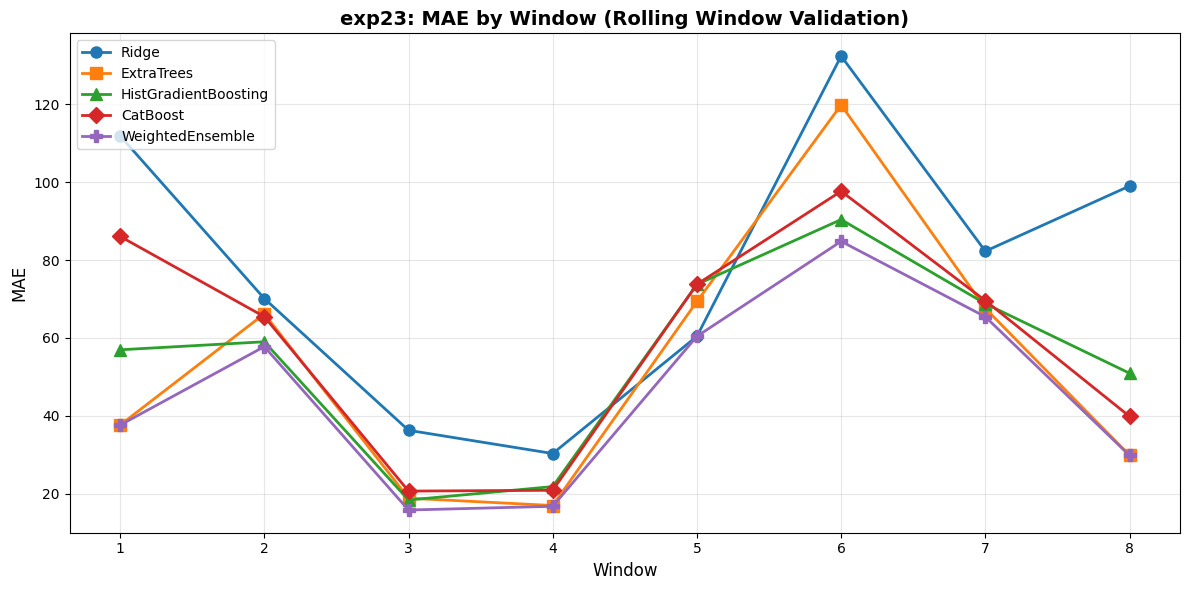


保存しました: ../output/exp23/mae_by_window.png


In [12]:
# ==================================================================================
# ウィンドウ別推移の可視化
# ==================================================================================

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

models_to_plot = ['Ridge', 'ExtraTrees', 'HistGradientBoosting', 'CatBoost', 'WeightedEnsemble']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
markers = ['o', 's', '^', 'D', 'P']

for model, color, marker in zip(models_to_plot, colors, markers):
    model_data = results_df[results_df['model'] == model]
    ax.plot(model_data['window'], model_data['MAE'], f'{marker}-', 
            label=model, color=color, linewidth=2, markersize=8)

ax.set_xlabel('Window', fontsize=12)
ax.set_ylabel('MAE', fontsize=12)
ax.set_title('exp23: MAE by Window (Rolling Window Validation)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='upper left')
ax.grid(alpha=0.3)
ax.set_xticks(range(1, 9))

plt.tight_layout()
plt.savefig(f'{output_dir}/mae_by_window.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n保存しました: {output_dir}/mae_by_window.png")

---

## Summary

**exp23: exp22最適化パラメータ + Rolling Window Validation**

### 設定
- **特徴量**: exp22と同じ37個（冗長な特徴量を削減済み）
- **パラメータ**: exp22でOptuna最適化したパラメータ
- **検証方法**: Rolling Window Validation（8ウィンドウ）

### 比較対象
- **exp20**: 50特徴量 + exp19パラメータ + Rolling Window
- **exp22**: 37特徴量 + exp22パラメータ + Holdout

### 出力ファイル
1. `rolling_window_results.csv` - 全ウィンドウの結果
2. `rolling_window_avg_results.csv` - モデル別平均スコア
3. `exp20_vs_exp23_comparison.csv` - exp20との比較
4. `exp22_vs_exp23_comparison.csv` - exp22との比較
5. `mae_by_window.png` - ウィンドウ別MAE推移